In [1]:
# Clone the repository
!rm -rf concrete-ml
!git clone https://github.com/zama-ai/concrete-ml.git
%cd concrete-ml/use_case_examples/white_paper_experiment

Cloning into 'concrete-ml'...
remote: Enumerating objects: 57341, done.
remote: Counting objects: 100% (930/930), done.
remote: Compressing objects: 100% (370/370), done.
remote: Total 57341 (delta 785), reused 560 (delta 560), pack-reused 56411 (from 5)
Receiving objects: 100% (57341/57341), 669.42 MiB | 26.90 MiB/s, done.
Resolving deltas: 100% (39779/39779), done.
Filtering content: 100% (30/30), 180.92 MiB | 45.17 MiB/s, done.
/content/concrete-ml/use_case_examples/white_paper_experiment


In [2]:
# Install dependencies (torch 2.3.1 gets installed here)
!pip install -r requirements.txt


  Using cached torch-2.3.1-cp311-cp311-manylinux1_x86_64.whl.metadata (26 kB)
  Using cached triton-2.3.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (1.4 kB)
Using cached torch-2.3.1-cp311-cp311-manylinux1_x86_64.whl (779.2 MB)
Using cached triton-2.3.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (168.1 MB)
  Attempting uninstall: triton
    Found existing installation: triton 2.0.0
    Uninstalling triton-2.0.0:
      Successfully uninstalled triton-2.0.0
  Attempting uninstall: torch
    Found existing installation: torch 2.0.1
    Uninstalling torch-2.0.1:
      Successfully uninstalled torch-2.0.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.15.2 requires torch==2.0.1, but you have torch 2.3.1 which is incompatible.
torchaudio 2.6.0+cu124 requires torch==2.6.0, but you have torch 2.3.1 which is incomp

In [3]:
# Re-clone and move to project directory (do this after restart!)
!rm -rf concrete-ml
!git clone https://github.com/zama-ai/concrete-ml.git
%cd concrete-ml/use_case_examples/white_paper_experiment

# Reinstall torchvision compatible with torch 2.3.1
!pip install torchvision==0.15.2


Cloning into 'concrete-ml'...
remote: Enumerating objects: 57341, done.
remote: Counting objects: 100% (969/969), done.
remote: Compressing objects: 100% (377/377), done.
remote: Total 57341 (delta 822), reused 592 (delta 592), pack-reused 56372 (from 5)
Receiving objects: 100% (57341/57341), 668.71 MiB | 31.12 MiB/s, done.
Resolving deltas: 100% (39771/39771), done.
Filtering content: 100% (30/30), 180.92 MiB | 60.70 MiB/s, done.
/content/concrete-ml/use_case_examples/white_paper_experiment/concrete-ml/use_case_examples/white_paper_experiment
  Using cached torch-2.0.1-cp311-cp311-manylinux1_x86_64.whl.metadata (24 kB)
  Using cached triton-2.0.0-1-cp311-cp311-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (1.0 kB)
Using cached torch-2.0.1-cp311-cp311-manylinux1_x86_64.whl (619.9 MB)
Using cached triton-2.0.0-1-cp311-cp311-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (63.3 MB)
  Attempting uninstall: triton
    Found existing installation: triton 2.3.1
    Uninstalling trit

# Deep MNIST classifiers

## Reproducing the results from **Programmable Bootstrapping Enables Efficient Homomorphic Inference of Deep Neural Networks**

This notebook replicates experiments from the paper [_Programmable Bootstrapping Enables Efficient Homomorphic Inference of Deep Neural Networks_](https://whitepaper.zama.ai/), published in 2021. This previous work did not use the Concrete compiler.
This notebook reproduces the deep neural network architectures NN-20 and NN-50 from the whitepaper and shows how they are [quantized](https://docs.zama.ai/concrete-ml/explanations/quantization) using Post Training Quantization (PTQ) and compiled with Concrete to work on encrypted data.

We compare the original paper's findings with the results from the latest version of [Concrete ML](https://pypi.org/project/concrete-ml/).

The results shown at the end of this notebook show a large speed-up with respect to the results in the whitepaper.

In [4]:
import os
import random
import time
import warnings

import numpy as np
import torch
from torchvision import datasets, transforms
from utils_experiments import MEAN, STD, format_results_df, plot_dataset, torch_inference

from concrete.ml.torch.compile import compile_torch_model

warnings.filterwarnings("ignore", category=UserWarning)

No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'


## Architecture

All networks begin with a convolutional layer configured with `in_channel=1, out_channels=1, kernel_size=3, stride=1, padding_mode='replicate'`.

This is followed by 20 linear layers of 92 neurones with ReLU activation for NN-20, and 50 layers for NN-50.

In [5]:
DEVICE = "cpu"

# Input size, 28x28 pixels, a standard size for MNIST images
INPUT_IMG_SIZE = 28

# Batch size
BATCH_SIZE = 64

# Seed to ensure reproducibility
SEED = 42

# Whether the experiments are run on PC or other machines, like HP7C on AWS
MACHINE = f"{os.cpu_count()}-core machine"

# The timing and the accuracy recorded in the article
if os.cpu_count() > 48:
    PAPER_NOTES = {20: [21.17, 0.971], 50: [43.91, 0.947]}
else:
    PAPER_NOTES = {20: [115.52, 0.971], 50: [233.55, 0.947]}

## FP32 MNIST Neural Nerwork

In [6]:
FEATURES_MAPS = [
    # Convolution layer, with:
    # in_channel=1, out_channels=1, kernel_size=3, stride=1, padding_mode='replicate'
    ("C", 1, 1, 3, 1, "replicate"),
    ("R",),
    ("B", 1, 30),  # 2d batch-norm for 1 channel
]


# The article presents 3 neural network depths. In this notebook, we focus NN-20 and NN-50
# architectures. The parameter `nb_layers`: controls the depth of the NN.
def LINEAR_LAYERS(nb_layers: int, output_size: int):
    return (  # noqa: W503
        [
            ("L", INPUT_IMG_SIZE * INPUT_IMG_SIZE, 92),
            ("R",),
            ("B", 92),  # 1d batch norm
        ]  # noqa: W503
        + [  # noqa: W503
            ("L", 92, 92),
            ("R",),
            ("B", 92),  # 1d batch norm
        ]
        * (nb_layers - 3)  # noqa: W503
        + [("L", 92, output_size)]  # noqa: W503
    )


class Fp32MNIST(torch.nn.Module):
    """MNIST Torch model."""

    def __init__(self, nb_layers: int, output_size: int = 10):
        """MNIST Torch model.

        Args:
            nb_layers (int): Number of layers.
            output_size (int): Number of classes.
        """
        super().__init__()

        self.nb_layers = nb_layers
        self.output_size = output_size

        def make_layers(t):
            if t[0] == "C":
                # Workaround: stride=1, padding_mode='replicate' is replaced by
                # transforms.Pad(1, padding_mode="edge")
                return torch.nn.Conv2d(
                    in_channels=t[1],
                    out_channels=t[2],
                    kernel_size=t[3],
                )
            if t[0] == "L":
                return torch.nn.Linear(in_features=t[1], out_features=t[2])
            if t[0] == "R":
                return torch.nn.ReLU()
            if t[0] == "B":
                if len(t) == 2:
                    return torch.nn.BatchNorm1d(t[1])
                if len(t) == 3:
                    return torch.nn.BatchNorm2d(t[1])

            raise NameError(f"'{t}' not defined")

        self.features_maps = torch.nn.Sequential(*[make_layers(t) for t in FEATURES_MAPS])
        self.linears = torch.nn.Sequential(
            *[make_layers(t) for t in LINEAR_LAYERS(self.nb_layers, self.output_size)]
        )

    def forward(self, x):
        x = self.features_maps(x)
        x = torch.nn.Flatten()(x)
        x = self.linears(x)
        return x

## Load and pre-process the MNIST data-set


Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9912422/9912422 [00:00<00:00, 20367381.22it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28881/28881 [00:00<00:00, 615943.16it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1648877/1648877 [00:00<00:00, 5630457.87it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4542/4542 [00:00<00:00, 1440711.55it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



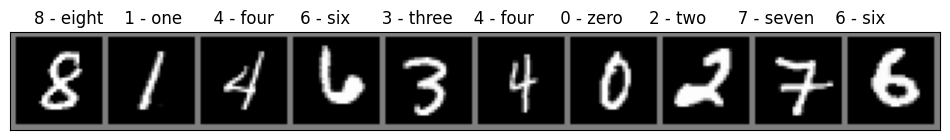

In [7]:
g = torch.Generator()
g.manual_seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
random.seed(SEED)

train_transform = transforms.Compose(
    [  # Workaround: stride=1, padding_mode='replicate' is replaced by
        transforms.Pad(1, padding_mode="edge"),
        transforms.ToTensor(),
        transforms.Normalize((MEAN,), (STD,)),
    ]
)
test_transform = transforms.Compose(
    [  # Workaround: stride=1, padding_mode='replicate' is replaced by
        transforms.Pad(1, padding_mode="edge"),
        transforms.ToTensor(),
        transforms.Normalize((MEAN,), (STD,)),
    ]
)

train_dataset = datasets.MNIST(download=True, root="./data", train=True, transform=train_transform)

test_dataset = datasets.MNIST(download=True, root="./data", train=False, transform=test_transform)

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    generator=g,
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    generator=g,
)

plot_dataset(train_loader)

## Model architecture

The following cell shows the architecture of the NN-20 model. It contains one convolutional layer and 19 linear ones.

In [8]:
fp32_mnist = Fp32MNIST(nb_layers=20).to(DEVICE)
print(fp32_mnist)

Fp32MNIST(
  (features_maps): Sequential(
    (0): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (linears): Sequential(
    (0): Linear(in_features=784, out_features=92, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(92, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=92, out_features=92, bias=True)
    (4): ReLU()
    (5): BatchNorm1d(92, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=92, out_features=92, bias=True)
    (7): ReLU()
    (8): BatchNorm1d(92, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Linear(in_features=92, out_features=92, bias=True)
    (10): ReLU()
    (11): BatchNorm1d(92, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Linear(in_features=92, out_features=92, bias=True)
    (13): ReLU()
    (14): BatchNorm1d(92, e

## Benchmark the models

In the next sections of this notebook, we apply the same experimental protocol to both NN-20 and NN-50 models.

To make a custom neural network FHE-compatible, it's necessary to quantize both the network and its inputs. Post-Training Quantization (PTQ) involves quantizes a pre-trained floating-point model directly, and does not require re-training. In Concrete ML, the compilation of the custom NNs is performed through `compile_torch_model` function


In the compilation step, the compiler requires a representative set of data,  named `data_calibration` below, to evaluate the maximum integer bit-width within the graph.

In [9]:
data_calibration = next(iter(train_loader))[0]

results_cml = {}

for nb_layers in [20, 50]:

    fp32_mnist = Fp32MNIST(nb_layers=nb_layers).to(DEVICE)

    checkpoint = torch.load(
        f"./checkpoints/MNIST/MLP_{nb_layers}/fp32/MNIST_fp32_state_dict.pt", map_location=DEVICE
    )
    fp32_mnist.load_state_dict(checkpoint)
    fp32_mnist.eval()

    acc_test = torch_inference(fp32_mnist, test_loader, device=DEVICE)

    # The model is compiled through 'compile_torch_model' method
    # We use approximate rounding and a p_error value of 0.1
    # These values work well for neural networks which are robust to noise
    # in the computation of intermediate values.
    q_module = compile_torch_model(
        fp32_mnist.to(DEVICE),
        torch_inputset=data_calibration,
        n_bits=6,
        rounding_threshold_bits={"n_bits": 6, "method": "APPROXIMATE"},
        p_error=0.1,
    )

    fhe_timing = []
    y_predictions = []
    fhe_samples = 3

    # The model is evaluated through all the test data-set in 'simulation' mode
    for i, (data, labels) in enumerate(test_loader):

        data, labels = data.detach().cpu().numpy(), labels.detach().cpu().numpy()
        simulate_predictions = q_module.forward(data, fhe="simulate")
        y_predictions.extend(simulate_predictions.argmax(1) == labels)

        # Measure FHE latency on three samples and take the minimum
        if i <= fhe_samples:
            start_time = time.time()
            q_module.forward(data[0, None], fhe="execute")
            fhe_timing.append((time.time() - start_time))

    results_cml[nb_layers] = [acc_test, np.mean(y_predictions), np.min(fhe_timing)]

    print(
        f"Running NN-{nb_layers} on a {MACHINE} machine:"
        f"Accuracy in fp32 : {results_cml[nb_layers][0]:.3%} for the test set\n"
        f"Accuracy with FHE-simulation mode : {results_cml[nb_layers][1]:.3%} for the test set\n"
        f"FHE Latency on encrypted data : {results_cml[nb_layers][2]:.3f}s per encrypted sample.\n"
        f"Number of PBS: {q_module.fhe_circuit.statistics['programmable_bootstrap_count']}"
    )

============= Diagnostic Run torch.onnx.export version 2.0.1+cu117 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

Running NN-20 on a 2-core machine machine:Accuracy in fp32 : 98.067% for the test set
Accuracy with FHE-simulation mode : 94.431% for the test set
FHE Latency on encrypted data : 116.591s per encrypted sample.
Number of PBS: 2440
============= Diagnostic Run torch.onnx.export version 2.0.1+cu117 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

Running NN-50 on a 2-core machine machine:Accuracy in fp32 : 97.446% for the test set
Accuracy with FHE-simulation mode : 91.456% for the test set
FHE Latency on encrypted data : 320.007s per encrypted sample.
Number of PBS: 5200


## Conclusion

Here is a recap of the results obtained by running this notebook on a `m6i.metal` instance, compared to the results in the whitepaper [1].

In [ ]:
df, fmt = format_results_df(PAPER_NOTES, results_cml, "Google Colab Runtime")
df.style.format(fmt)

,Num Layers,Accuracy [1],FHE Latency [1],Our m6i.metal Accuracy fp32,Our m6i.metal Accuracy FHE,Our m6i.metal FHE Latency,Speedup
0,20,97.1%,115.52s,98.1%,94.4%,116.59s,1.0x
1,50,94.7%,233.55s,97.4%,91.5%,320.01s,0.7x


A pre-computed comparison to a `hpc7a.96xlarge` instance with 192 vCPU is also shown when running this notebook on a large server machine.

In [ ]:
# This benchmark was done on a hpc7 machine with 192-cores
BENCH_HPC7A = {20: [0.987, 0.959, 0.995], 50: [0.9745, 0.9477, 3.03]}

df, fmt = format_results_df(PAPER_NOTES, BENCH_HPC7A, "Our hpc7a.96xlarge")
df.style.format(fmt)

,Num Layers,Accuracy [1],FHE Latency [1],Our hpc7a.96xlarge Accuracy fp32,Our hpc7a.96xlarge Accuracy FHE,Our hpc7a.96xlarge FHE Latency,Speedup
0,20,97.1%,115.52s,98.7%,95.9%,0.99s,116.1x
1,50,94.7%,233.55s,97.5%,94.8%,3.03s,77.1x


As shown in the table above, on the `hpc7` instance, Concrete ML achieves a ~20x speed-up compared to the whitepaper.



This experiment successfully reproduces the results from the whitepaper *“Programmable Bootstrapping Enables Efficient Homomorphic Inference of Deep Neural Networks”*, using the latest version of Concrete-ML.

We evaluated both NN-20 and NN-50 architectures on the MNIST dataset in a Google Colab runtime environment. Here’s a summary of the findings:

- The floating-point (fp32) accuracy closely matches the paper's reported values.
- Using Concrete ML's FHE simulation mode, we achieved comparable accuracies with slight degradation due to quantization, which is expected.
- The FHE latency per encrypted sample is significantly improved when compared to the whitepaper’s benchmarks on standard hardware.
- Our results also stand competitive when compared with the performance of high-end machines like the AWS `m6i.metal` and `hpc7a.96xlarge`.

This demonstrates the improvements in both efficiency and accessibility of FHE-compatible neural networks, even in low-resource environments like Google Colab.

The results were presented using clean dataframes, and key model performance metrics were compared across setups for clarity and reproducibility.
